# BPMN2Constraints: Tutorial
This notebook provides a brief tutorial on how to use BPMN2Constraints in the context of a commercial business process management/process mining tool.

BPMN2Constraints is a tool that turns process models -- and in particular Business Process Model and Notation (BPMN) diagrams -- into declarative constraints in different formats.
In particular, DECLARE and LTL constraints are supported, as are regular expression-based constraints that can be contextualized and executed in SIGNAL, SAP Signavio's proprietary process querying language.
This tutorial gives a hands-on overview of how BPMN2Constraints works, show-casing an exemplaric integration with SAP Signavio's process modeling and process mining capabilities.

## Setup
First, we require the tool.

In [1]:
import sys
sys.path.append("../")

Then, we import the tool, alongside other imports that we need. Alternatively, we can run the tool from the command line, as explained in detail in the [README](./README.md) document. Note that in the example below we make use tutorial utilities that allow us to work with SAP Signavio APIs. These utilities are not generally required for using BPMN2Constraints, but they helps us illustrate how the tool works in interplay with enterprise-ready software.

In [2]:
from bpmnconstraints.script import compile_bpmn_diagram
import SignavioAuthenticator
import requests
from IPython.display import Image, display
import json
import logging
logging.getLogger("urllib3").setLevel(logging.WARNING)

Let us now fetch and render a BPMN diagram. At the moment, BPMN-to-Constraints supports the JSON format for BPMN diagrams that SAP Signavio uses. However, let us highlight that hundreds of thousands of BPMN diagrams in this format exists in an [open data set](https://zenodo.org/record/7012043) and that API code for translating diagrams in JSON format into standard-compliant XML is provided in a [different repository](https://github.com/signavio/sap-sam/blob/main/notebooks/3_images_and_XMLs.ipynb) (The inverse, i.e. XML to JSON can be achieved in an analogous manner). As a prerequisite, we need to specify system instance, workspace ID, and credentials. 

In [3]:
system_instance = 'https://editor.signavio.com'
workspace_id = # workspace id
user_name = # username
pw = # pw

In addition, we provide the ID of the diagram -- technically, the diagram _revision_ (version) -- that we want to translate into constraints.

In [4]:
revision_id = '1fe7397c17304d3ba4ea41f1eefc97fe'

Now we can fetch and render the BPMN diagram.

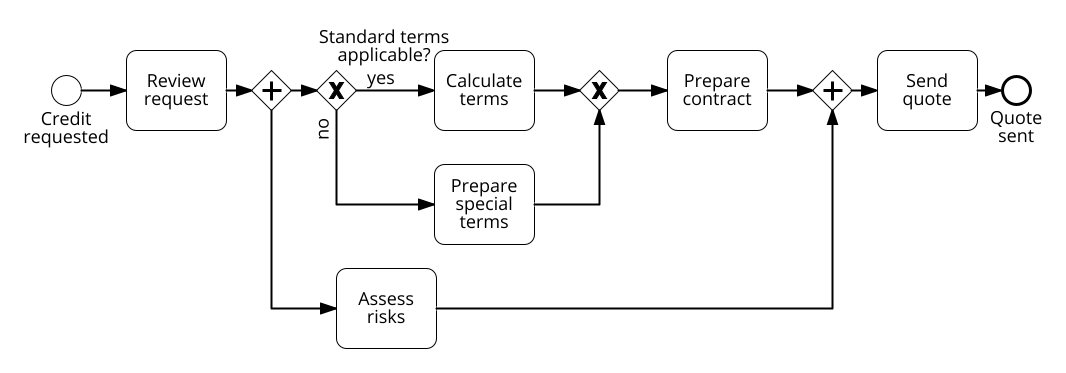

In [5]:
authenticator = SignavioAuthenticator.SignavioAuthenticator(system_instance, workspace_id, user_name, pw)
auth_data = authenticator.authenticate()
cookies = {'JSESSIONID': auth_data['jsesssion_ID'], 'LBROUTEID': auth_data['lb_route_ID']}
headers = {'Accept': 'application/json', 'x-signavio-id':  auth_data['auth_token']}
diagram_url = system_instance + '/p/revision'

json_request = requests.get(
    f'{diagram_url}/{revision_id}/json',
    cookies=cookies,
    headers=headers)
json_diagram = json_request.content
path = './diagram.json'
with open(path, 'w') as f:
    json.dump(json.loads(json_diagram), f)
png_request = requests.get(
    f'{diagram_url}/{revision_id}/png',
    cookies=cookies,
    headers=headers)
display(Image(png_request.content))


We break-down the diagram into constraints of different types.
Let us start with DECLARE constraints.

In [6]:
declare_constraints = compile_bpmn_diagram(path, "DECLARE", False)
print(declare_constraints)

Succession[review request, AND]
Co-Existence[AND, review request]
Choice[AND, review request]
Alternate Succession[review request, AND]
Choice[prepare special terms, AND]
Choice[calculate terms, AND]
Succession[calculate terms, XOR]
Co-Existence[XOR, calculate terms]
Alternate Succession[calculate terms, XOR]
Succession[prepare contract, AND]
Co-Existence[AND, prepare contract]
Choice[AND, prepare contract]
Alternate Succession[prepare contract, AND]
Succession[prepare special terms, XOR]
Co-Existence[XOR, prepare special terms]
Alternate Succession[prepare special terms, XOR]
Succession[assess risks, AND]
Co-Existence[AND, assess risks]
Alternate Succession[assess risks, AND]
INFO:root:Generating LTLF constraints...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 224109.95it/s]

['review_request', 'Not translatable', 'Not translatable', 'Not translatable', 'Not translatable', '(G((review_request) -> (F(prepare_contract)))) & (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract))))', '((F(prepare_contract)) -> (F(review_request))) & ((F(review_request)) -> (F(prepare_contract)))', '(F(prepare_contract)) | (F(review_request))', '(G((review_request) -> (X[!]((~(review_request)) U (prepare_contract))))) & (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract)))) & (G((prepare_contract) -> (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract))))))', '(G((review_request) -> (F(send_quote)))) & (((~(send_quote)) U (review_request)) | (G(~(send_quote))))', '((F(send_quote)) -> (F(review_request))) & ((F(review_request)) -> (F(send_quote)))', '(F(send_quote)) | (F(review_request))', '(G((review_request) -> (X[!]((~(review_request)) U (send_quote))))) & (((~(send_quote)) U (review_request)) | (G(~(send_quote)))) & (G((send_quo

Now, let us generate LTLf constraints.

In [7]:
ltlf_constraints = compile_bpmn_diagram(path, "LTLF", False)
print(ltlf_constraints)

Succession[review request, AND]
Co-Existence[AND, review request]
Choice[AND, review request]
Alternate Succession[review request, AND]
Choice[prepare special terms, AND]
Choice[calculate terms, AND]
Succession[calculate terms, XOR]
Co-Existence[XOR, calculate terms]
Alternate Succession[calculate terms, XOR]
Succession[prepare contract, AND]
Co-Existence[AND, prepare contract]
Choice[AND, prepare contract]
Alternate Succession[prepare contract, AND]
Succession[prepare special terms, XOR]
Co-Existence[XOR, prepare special terms]
Alternate Succession[prepare special terms, XOR]
Succession[assess risks, AND]
Co-Existence[AND, assess risks]
Alternate Succession[assess risks, AND]
INFO:root:Generating LTLF constraints...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 828661.88it/s]

['review_request', 'Not translatable', 'Not translatable', 'Not translatable', 'Not translatable', '(G((review_request) -> (F(prepare_contract)))) & (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract))))', '((F(prepare_contract)) -> (F(review_request))) & ((F(review_request)) -> (F(prepare_contract)))', '(F(prepare_contract)) | (F(review_request))', '(G((review_request) -> (X[!]((~(review_request)) U (prepare_contract))))) & (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract)))) & (G((prepare_contract) -> (((~(prepare_contract)) U (review_request)) | (G(~(prepare_contract))))))', '(G((review_request) -> (F(send_quote)))) & (((~(send_quote)) U (review_request)) | (G(~(send_quote))))', '((F(send_quote)) -> (F(review_request))) & ((F(review_request)) -> (F(send_quote)))', '(F(send_quote)) | (F(review_request))', '(G((review_request) -> (X[!]((~(review_request)) U (send_quote))))) & (((~(send_quote)) U (review_request)) | (G(~(send_quote)))) & (G((send_quo

Finally, we generate constraints in SIGNAL, SAP Signavio's process data querying language.

In [8]:
signal_constraints = compile_bpmn_diagram(path, "SIGNAL", False)
print(signal_constraints)

Succession[review request, AND]
Co-Existence[AND, review request]
Choice[AND, review request]
Alternate Succession[review request, AND]
Choice[prepare special terms, AND]
Choice[calculate terms, AND]
Succession[calculate terms, XOR]
Co-Existence[XOR, calculate terms]
Alternate Succession[calculate terms, XOR]
Succession[prepare contract, AND]
Co-Existence[AND, prepare contract]
Choice[AND, prepare contract]
Alternate Succession[prepare contract, AND]
Succession[prepare special terms, XOR]
Co-Existence[XOR, prepare special terms]
Alternate Succession[prepare special terms, XOR]
Succession[assess risks, AND]
Co-Existence[AND, assess risks]
Alternate Succession[assess risks, AND]
INFO:root:Generating SIGNAL constraints...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 977167.60it/s]

["(^'review request')", "(^NOT('review request'|'AND')*('review request'~>'AND')*NOT('review request'|'AND')*$)", "(^NOT(review request|AND)*((review requestANY*ANDANY*)|(ANDANY* 'review request' ANY*))* NOT('review request'|'AND')*$)", "('review request'|'AND')", "( ^ NOT('review request'|'AND')* ('review request'NOT('review request'|'AND')*'AND'NOT('review request'|'AND')*)*NOT('review request'|'AND')* $)", "(^NOT('review request'|'prepare contract')*('review request'~>'prepare contract')*NOT('review request'|'prepare contract')*$)", "(^NOT(review request|prepare contract)*((review requestANY*prepare contractANY*)|(prepare contractANY* 'review request' ANY*))* NOT('review request'|'prepare contract')*$)", "('review request'|'prepare contract')", "( ^ NOT('review request'|'prepare contract')* ('review request'NOT('review request'|'prepare contract')*'prepare contract'NOT('review request'|'prepare contract')*)*NOT('review request'|'prepare contract')* $)", "(^NOT('review request'|'send

We can use these constraints, in combination with SIGNAL templates, to query an event log that has been uploaded to SAP Signavio Process Intelligence. For this, we first need to embedd the results of the constraints generate into a SIGNAL query template.

In [9]:
def signal_template(constraint):
    return f'SELECT COUNT(CASE_ID) FROM "defaultview-4" WHERE NOT event_name MATCHES{constraint}'

Then, we can send the query for execution to the backend system.

In [10]:
signal_endpoint = system_instance + '/g/api/pi-graphql/signal'
constraint_violations = {}
for constraint in signal_constraints:
    query_request = requests.post(
        signal_endpoint,
        cookies=cookies,
        headers=headers,
        json={'query': signal_template(constraint)})
    if 'data' in query_request.json(): constraint_violations[constraint] = query_request.json()['data'][0][0]

In [11]:
print(constraint_violations)

{"(^'review request')": 94.0, "(^NOT('review request'|'AND')*('review request'~>'AND')*NOT('review request'|'AND')*$)": 100.0, "( ^ NOT('review request'|'AND')* ('review request'NOT('review request'|'AND')*'AND'NOT('review request'|'AND')*)*NOT('review request'|'AND')* $)": 100.0, "(^NOT('review request'|'prepare contract')*('review request'~>'prepare contract')*NOT('review request'|'prepare contract')*$)": 20.0, "( ^ NOT('review request'|'prepare contract')* ('review request'NOT('review request'|'prepare contract')*'prepare contract'NOT('review request'|'prepare contract')*)*NOT('review request'|'prepare contract')* $)": 98.0, "(^NOT('review request'|'send quote')*('review request'~>'send quote')*NOT('review request'|'send quote')*$)": 10.0, "( ^ NOT('review request'|'send quote')* ('review request'NOT('review request'|'send quote')*'send quote'NOT('review request'|'send quote')*)*NOT('review request'|'send quote')* $)": 96.0, "(^ (NOT 'review request' | ('review request' (NOT 'review

Let us now analyze the results. For the sake of simplicity, we focus on the conformance violation count and the conformance rate for two particular constraint.
First, we count the total number of cases.

In [12]:
count_request = requests.post(
    signal_endpoint,
    cookies=cookies,
    headers=headers,
    json={'query': 'SELECT COUNT(CASE_ID) FROM "defaultview-4"'})
case_count = count_request.json()['data'][0][0]
print(case_count)

100.0


Let us now determine the number of violations of the `(^'review request')` constraint (a case should start with the `review request` event), as well as the relative occurence of the violation in percent.

In [13]:
print("Number of violations", constraint_violations["(^'review request')"])
print("Conformance rate", (1 - constraint_violations["(^'review request')"] / case_count) * 100)

Number of violations 94.0
Conformance rate 6.000000000000005
